In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Part A: Build a classification model using text data

In [2]:
text_data = pd.read_csv("text_training_data.csv")
text_data.head()

,headline,label
0,MyBook Disk Drive Handles Lots of Easy Backups,not clickbait
1,CIT Posts Eighth Loss in a Row,not clickbait
2,"Candy Carson Singing The ""National Anthem"" Is ...",clickbait
3,Why You Need To Stop What You're Doing And Dat...,clickbait
4,27 Times Adele Proved She's Actually The Reale...,clickbait


In [3]:
#NOTE: THIS CODE IS FROM WEEK 10 CLASS CODE
# Helper function to plot top positive and negative coefficients

def visualize_coefficients(coefficients, feature_names, n_top_features=25):
    """Visualize coefficients of a linear model.
    Parameters
    ----------
    coefficients : nd-array, shape (n_features,)
        Model coefficients.
    feature_names : list or nd-array of strings, shape (n_features,)
        Feature names for labeling the coefficients.
    n_top_features : int, default=25
        How many features to show. The function will show the largest (most
        positive) and smallest (most negative)  n_top_features coefficients,
        for a total of 2 * n_top_features coefficients.
    """
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        # this is not a row or column vector
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    # get coefficients with large absolute values
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ['#ff2020' if c < 0 else '#0000aa'
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features),
               feature_names[interesting_coefficients], rotation=60,
               ha="right")
    plt.ylabel("Coefficient magnitude")
    plt.xlabel("Feature")

CountVectorizer + GridSearchCV + LogisticRegression

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_cv = pd.DataFrame(cv.fit_transform(text_data["headline"]).toarray())
y = text_data['label'].map({'clickbait': 1, 'not clickbait': 0})

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_cv, y, train_size=0.3, random_state=110)
X_train.shape

(7493, 20332)

In [7]:
param_grid = {
    'C': [0.1, 1, 10, 100],
}
lr = LogisticRegression()
grid = GridSearchCV(lr, param_grid, cv=5, scoring = 'f1')

In [8]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10, 100]}, scoring='f1')

In [9]:
print("Best Parameters:", grid.best_params_)
print("Best score: ", grid.best_score_)
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
score = f1_score(y_test, y_pred)
print("F1 score: ", score)

Best Parameters: {'C': 100}
Best score:  0.9630477889888389
F1 score:  0.9588615163836403


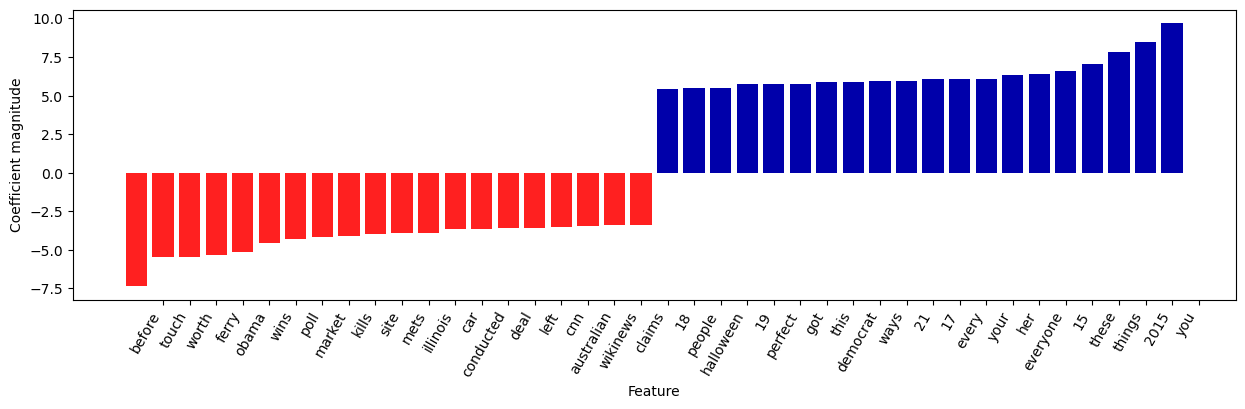

In [10]:
visualize_coefficients(best_model.coef_[0], cv.get_feature_names_out(), n_top_features=20)

LogisticRegression + TfidVectorizer + GridSearchCV

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer()
X_tf = pd.DataFrame(tf.fit_transform(text_data["headline"]).toarray())

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_tf, y, train_size=0.2, random_state=110)
X_train.shape

(4995, 20332)

Best Parameters: {'C': 100}
Best score:  0.9623268177651176
F1 score:  0.9562709731543624


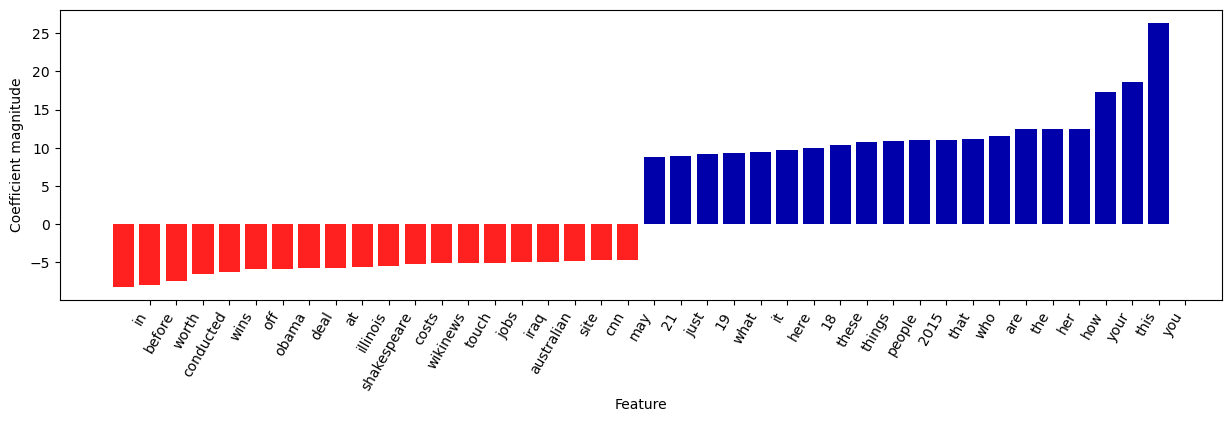

In [13]:
param_grid = {
    'C': [0.1, 1, 10, 100],
}
lr = LogisticRegression()
grid = GridSearchCV(lr, param_grid, cv=5, scoring = 'f1')
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)
print("Best score: ", grid.best_score_)
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
score = f1_score(y_test, y_pred)
print("F1 score: ", score)
visualize_coefficients(best_model.coef_[0], cv.get_feature_names_out(), n_top_features=20)

LogisticRegression + CountVectorizer + GridSearchCV + Lemmatizer (PorterStemmer)

In [14]:
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

stemmer = nltk.stem.PorterStemmer()

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

lv = CountVectorizer(tokenizer=LemmaTokenizer())
X_lv = pd.DataFrame(lv.fit_transform(text_data["headline"]).toarray())


/opt/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_lv, y, train_size=0.2, random_state=110)
X_train.shape

(4995, 19650)

In [16]:
param_grid = {
    'C': [0.1, 1, 10, 100],
}
lr = LogisticRegression()
grid = GridSearchCV(lr, param_grid, cv=5, scoring = 'f1')
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)
print("Best score: ", grid.best_score_)
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
score = f1_score(y_test, y_pred)
print("F1 score: ", score)

Best Parameters: {'C': 100}
Best score:  0.9664784529506232
F1 score:  0.9615665034892199


The Logistic Regression + Grid Search + Lemmetization had the best performance. The best parameters are {'C': 100}. But they are all good.


# Part B: Build a Predictive Neural Network Using Keras

In [17]:
data = pd.read_csv("http://vincentarelbundock.github.io/Rdatasets/csv/datasets/iris.csv")
data.head()
data.drop(columns=['rownames'])

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [18]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD

In [19]:
data = data.iloc[:,1:]
X = data.loc[:, data.columns != 'Species']
y = data['Species']
X

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [20]:
y = keras.utils.to_categorical(data['Species'].map({'setosa': 0, 'versicolor': 1, 'virgi|nica': 2}), num_classes=3)

/opt/anaconda3/lib/python3.10/site-packages/pandas/core/series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


In [21]:
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=4))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))

/opt/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape)
print(y_train.shape)

(112, 4)
(112, 3)


In [24]:
model.fit(X_train, y_train,
          epochs=100,
          batch_size=20)
#score = model.evaluate(X, y, batch_size=150) # extract loss and accuracy from test data evaluation

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - accuracy: 0.4175 - loss: 0.8479
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - accuracy: 0.3207 - loss: 0.7702
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - accuracy: 0.3572 - loss: 0.7269
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.4351 - loss: 0.7079
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.6489 - loss: 0.6840
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.6478 - loss: 0.6808
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - accuracy: 0.6853 - loss: 0.6550
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - accuracy: 0.6511 - loss: 0.6635
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6760 - loss: 0.6384
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.6958 - loss: 0.6434
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.6841 - loss: 0.6347
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - accuracy: 0

In [25]:
score = model.evaluate(X_test, y_test, batch_size=128)
print(score)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7368 - loss: 0.3811
[0.3811020255088806, 0.7368420958518982]


In [26]:
#Second Model
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=4))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(X_train, y_train,
          epochs=100,
          batch_size=20)

score = model.evaluate(X_test, y_test, batch_size=128)
print(score)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.3807 - loss: 1.0368


/opt/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.6998 - loss: 0.7465
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.6697 - loss: 0.6915
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.6284 - loss: 0.6928
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.6715 - loss: 0.6444
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - accuracy: 0.6368 - loss: 0.6646
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - accuracy: 0.6710 - loss: 0.6377
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.6372 - loss: 0.6464
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6306 - loss: 0.6403
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.6592 - loss: 0.6145
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.6425 - loss: 0.6245
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - accuracy: 0.6548 - loss: 0.6073
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 

In [27]:
#Second Model
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=4))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(X_train, y_train,
          epochs=100,
          batch_size=20)

score = model.evaluate(X_test, y_test, batch_size=128)
print(score)

Epoch 1/100


/opt/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.6235 - loss: 1.0708
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - accuracy: 0.6640 - loss: 1.0219
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - accuracy: 0.6807 - loss: 0.9732
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.6618 - loss: 0.9420
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7147 - loss: 0.8856
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.6543 - loss: 0.8868
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - accuracy: 0.6835 - loss: 0.8448
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - accuracy: 0.5946 - loss: 0.8773
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - accuracy: 0.6449 - loss: 0.8215
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - accuracy: 0.6499 - loss: 0.8024
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - accuracy: 0.6280 - loss: 0.8049
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.6430 - loss

The data with 3 hidden layer has the highest result. Too much hidden layer does not give a better result, but will cause overfitting.